In [94]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from torch.nn import functional as F
from tqdm import tqdm
import gym


In [95]:
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Softmax())
        
    def forward(self,x):
        return self.fc2(self.fc1(x))

class ValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,x):
        return self.fc2(self.fc1(x))
        
## 广义优势估计
def compute_advantage(gamma,lmbda,td_delta):
    td_delta=td_delta.detach().numpy()
    advantage_list=[]
    advantages=0
    for delta in td_delta[::-1]:
        advantages=advantages*gamma*lmbda+delta
        advantage_list.append(advantages)
    advantage_list.reverse()
    return torch.Tensor(advantage_list)

class PPO():
    def __init__(self,state_dim,hidden_dim,action_dim,actor_lr,critic_lr,
                lmbda,epochs,eps,gamma,device):
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.critic=ValueNet(state_dim,hidden_dim).to(device)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=critic_lr)
        
        self.gamma=gamma
        self.eps=eps
        self.lmbda=lmbda
        self.epochs=epochs
        self.device=device
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        prods=self.actor(state)
        action_dist=torch.distributions.Categorical(prods)
        action=action_dist.sample()
        return action.item()
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target=rewards+self.gamma*self.critic(next_states)*(1-dones)
        td_delta=td_target-self.critic(states)
        advantage=compute_advantage(self.gamma,self.lmbda,td_delta.cpu()).to(self.device)
        
        old_log_probs=torch.log(self.actor(states).gather(1,actions)).detach()
        
        for epoch in range(self.epochs):
            log_probs=torch.log(self.actor(states).gather(1,actions))
            radio=torch.exp(log_probs-old_log_probs)
            surr1=radio*advantage
            surr2=torch.clamp(radio,1-self.eps,1+self.eps)*advantage
            actor_loss=torch.mean(-torch.min(surr1,surr2))
            critic_loss=torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
        

In [96]:
actor_lr=1e-3*1.5
critic_lr=1e-2*1.5
epochs=500
hidden_dim=64
gamma=0.98
lmbda=0.92
eps=0.2
epoch=10
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env_name='CartPole-v1'
env=gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epoch, eps, gamma, device)

return_list=[]                                                                       
for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1)and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append((done1 or done2))
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
    
                

iter 9: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s, epoch=548, return=500.000]


## 使用训练好的PPO采样作为专家数据

In [98]:
import random
def sample_expert_data(nums):
    states=[]
    actions=[]
    for _ in range(nums):
        state,_=env.reset(seed=0)
        done1=False
        done2=False
        while (not done1) and (not done2):
            action=agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state,reward,done1,done2,_=env.step(action)
            state=next_state
    return np.array(states),np.array(actions)

torch.manual_seed(0)
random.seed(0)
nums=1
expert_states,expert_actions=sample_expert_data(nums)

n_samples=30
random_index=random.sample(range(expert_states.shape[0]),n_samples)
expert_s=expert_states[random_index]
expert_a=expert_actions[random_index]
expert_s[:5],expert_a[:5]

(array([[-0.24090405, -0.01807867, -0.03592018, -0.15722801],
        [-0.3441631 ,  0.15181826,  0.0409494 ,  0.10654453],
        [-0.2719159 , -0.02534763,  0.01416309,  0.00321051],
        [-0.3607272 , -0.59811354,  0.02487605,  0.60342956],
        [-0.15355852,  0.54517275, -0.11175839, -0.55062914]],
       dtype=float32),
 array([0, 1, 0, 1, 0]))

## 行为克隆

In [12]:
class BehaviorClone():
    def __init__(self,state_dim,hidden_dim,action_dim,lr,device):
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer=torch.optim.Adam(self.actor.parameters(),lr=lr)
        self.device=device
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        probs=self.actor(state)
        action_dist=torch.distributions.Categorical(probs)
        action=action_dist.sample()
        return action.item()
    def update(self,states,actions):
        states=torch.Tensor(states).to(self.device)
        actions=torch.tensor(actions).view(-1,1).to(self.device)
        log_probs=torch.log(self.actor(states).gather(1,actions))
        bc_loss=-torch.mean(log_probs)
        
        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

        
def test_agent(agent,env,nums):
    return_list=[]
    for _ in range(nums):
        rewards=0
        state,_=env.reset(seed=0)
        done1=False
        done2=False
        while (not done1) and (not done2):
            action=agent.take_action(state)
            next_state,reward,done1,done2,_=env.step(action)
            state=next_state
            rewards+=reward
        return_list.append(rewards)
    return np.mean(return_list)

torch.manual_seed(0)
np.random.seed(0)

lr=1e-3
bc_agent=BehaviorClone(state_dim,hidden_dim,action_dim,lr,device)
epochs=1000
batch_size=64
test_return=[]

with tqdm(total=epochs,desc='进度条') as pbar:
    for i in range(epochs):
        sample_indices=np.random.randint(low=0,
                                        high=expert_s.shape[0],
                                        size=batch_size)
        bc_agent.update(expert_s[sample_indices],expert_a[sample_indices])
        current_return=test_agent(bc_agent,env,5)
        test_return.append(current_return)
        
        if (i+1)%10==0:
            pbar.set_postfix({
                'return': '%.3f'%np.mean(test_return[-10:])
            })
        pbar.update(1)

进度条: 100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s, return=499.940]


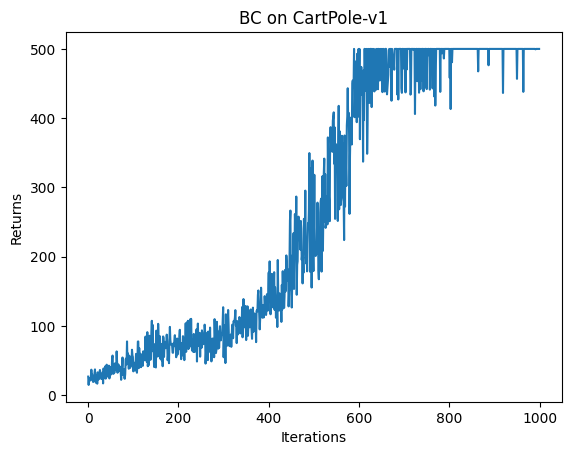

In [15]:
iteration_list = list(range(len(test_return)))
plt.plot(iteration_list, test_return)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()

## 生成式对抗模仿学习

In [99]:
class Discriminator(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim+action_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,1),nn.Sigmoid())
    def forward(self,s,a):
        x=torch.cat([s,a],dim=-1)
        return self.fc2(self.fc1(x))

In [90]:
class GAIL():
    def __init__(self,agent,state_dim,action_dim,hidden_dim,lr_d,device):
        self.d=Discriminator(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer=torch.optim.Adam(self.d.parameters(),lr=lr_d)
        self.agent=agent
        self.device=device
        self.d_loss=[]
        self.policy_loss=[]
    
    def update(self,expert_s,expert_a,agent_s,agent_a,next_s,dones):
        expert_states=torch.Tensor(expert_s).to(self.device)
        expert_actions=torch.tensor(expert_a).to(self.device)
        agent_states=torch.Tensor(agent_s).to(self.device)
        agent_actions=torch.tensor(agent_a).to(self.device)
        expert_actions=F.one_hot(expert_actions,num_classes=2).float()
        agent_actions=F.one_hot(agent_actions,num_classes=2).float()
        expert_prob=self.d(expert_states,expert_actions)
        agent_prob=self.d(agent_states,agent_actions)
        ## 两种写法都可以
        ## 用MSE
        loss=nn.MSELoss()
        d_loss=(loss(agent_prob,torch.zeros_like(agent_prob))+loss(expert_prob,torch.ones_like(expert_prob)))
        self.optimizer.zero_grad()
        d_loss.backward()
        self.optimizer.step()
        rewards=((agent_prob-torch.zeros_like(agent_prob))**2).detach().cpu().numpy()
        """##用BCE
        loss=nn.BCELoss()
        d_loss=(loss(agent_prob,torch.ones_like(agent_prob))+loss(expert_prob,torch.zeros_like(expert_prob)))
        
        self.optimizer.zero_grad()
        d_loss.backward()
        self.optimizer.step()
        
        ## 使用判别器损失作为rewards
        rewards=-torch.log(agent_prob).detach().cpu().numpy()
        """
        trans_dict={
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(trans_dict)
        self.d_loss.append(d_loss.item())
        self.policy_loss.append(rewards.mean())
    def plot(self):
        n=len(self.d_loss)
        plt.plot(range(n),self.d_loss)
        plt.plot(range(n),self.policy_loss)
        plt.show()
        

## 使用PPO作为策略网络

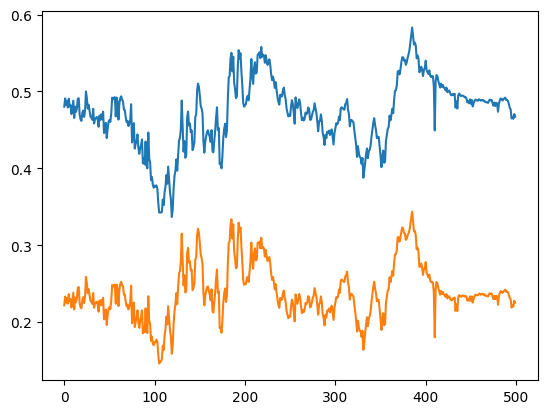

进度条: 100%|██████████| 500/500 [03:54<00:00,  2.13it/s, return=500.000]


In [103]:
from IPython.display import clear_output
import time
lr_d = 5e-4
actor_lr=1e-3*1.5
critic_lr=1e-2*1.5
epochs=500
hidden_dim=64
gamma=0.98
lmbda=0.92
eps=0.2
epoch=10
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env_name='CartPole-v1'
env=gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epoch, eps, gamma, device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d,device)
return_list = []
with tqdm(total=epochs,desc='进度条') as pbar:
    for i in range(epochs):
        rewards=0
        state,_=env.reset(seed=0)
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
                
        done1=False
        done2=False
        while (not done1) and (not done2):
            action=agent.take_action(state)
            next_state,reward,done1,done2,_=env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done=done1 or done2
            done_list.append(done)
            state=next_state
            rewards+=reward

        return_list.append(rewards)
        gail.update(expert_s,expert_a,state_list,action_list,next_state_list,done_list)
        
        if (i+1)%10==0:
            pbar.set_postfix({
                'return': '%.3f'%np.mean(return_list[-10:])
            })
        if (i+1)%50==0:
            clear_output()
            gail.plot()
            
        pbar.update(1)
        time.sleep(0.1)


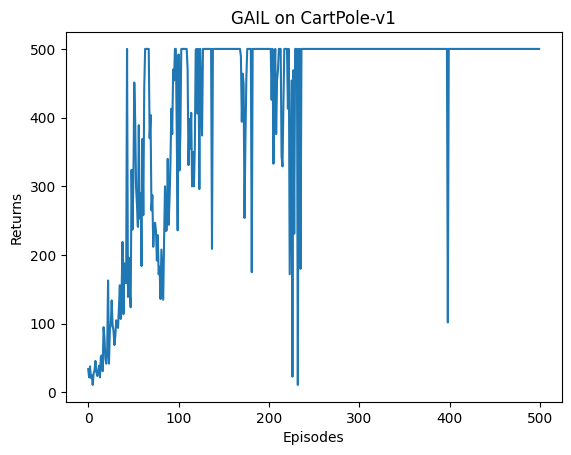

In [82]:
## 使用交叉熵损失
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

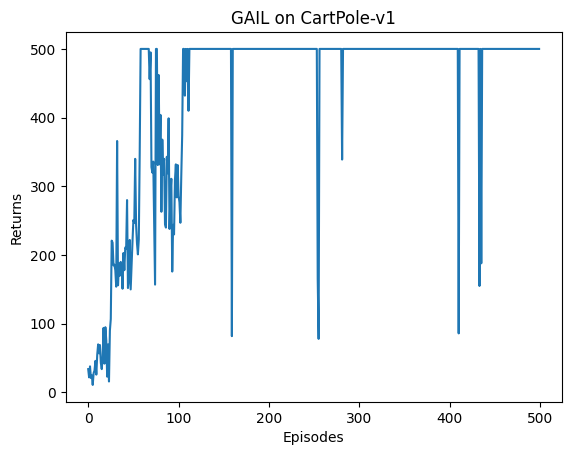

In [104]:
## 使用MSE损失
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

## 使用A2C作为策略网络

In [100]:
## 策略网络
## 输入状态，输出选择每个动作的概率
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Softmax())
    def forward(self,x):
        return self.fc2(self.fc1(x))
    
## 价值网络
## 输入状态，输出状态平均的价值
class ValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,x):
        return self.fc2(self.fc1(x))

class Actor_Critic():
    def __init__(self,state_dim,hidden_dim,action_dim,gamma,actor_lr,critic_lr,device):
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.critic=ValueNet(state_dim,hidden_dim).to(device)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.device=device
        self.gamma=gamma
    def take_action(self,state):
        state=torch.FloatTensor(state).unsqueeze(0).to(device)
        prod=self.actor(state)
        action_dist=torch.distributions.Categorical(prod)
        action=action_dist.sample()
        return action.item()
    
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target=rewards+self.gamma*self.critic(next_states)*(1-dones)
        td_delta=td_target-self.critic(states)
        log_prods=torch.log(self.actor(states).gather(1,actions))
        
        actor_loss=torch.mean(-log_prods*td_delta.detach())
        
        critic_loss=torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

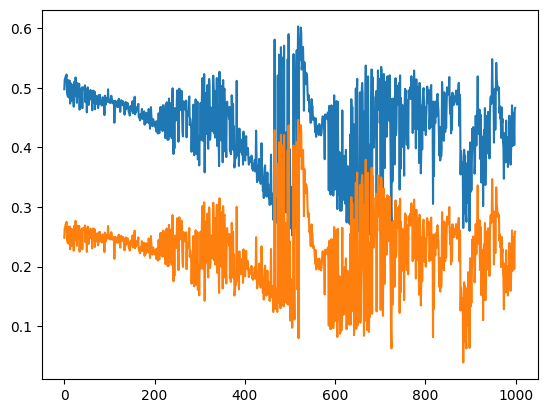

进度条: 100%|██████████| 1000/1000 [05:26<00:00,  3.06it/s, return=500.000]


In [101]:
import time
lr_d = 3e-4
actor_lr = 1e-3
critic_lr = 1e-2
epochs = 1000
hidden_dim = 128
gamma = 0.98
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = Actor_Critic(state_dim, hidden_dim, action_dim,gamma,actor_lr, critic_lr,device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d,device)
return_list = []
with tqdm(total=epochs,desc='进度条') as pbar:
    for i in range(epochs):
        rewards=0
        state,_=env.reset(seed=0)
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
                
        done1=False
        done2=False
        while (not done1) and (not done2):
            action=agent.take_action(state)
            next_state,reward,done1,done2,_=env.step(action)
            
            
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done=done1 or done2
            done_list.append(done)
            state=next_state
            rewards+=reward

        return_list.append(rewards)
        gail.update(expert_s,expert_a,state_list,action_list,next_state_list,done_list)
        
        if (i+1)%10==0:
            pbar.set_postfix({
                'return': '%.3f'%np.mean(return_list[-10:])
            })
        if (i+1)%50==0:
            clear_output()
            gail.plot()
        pbar.update(1)
        time.sleep(0.1)


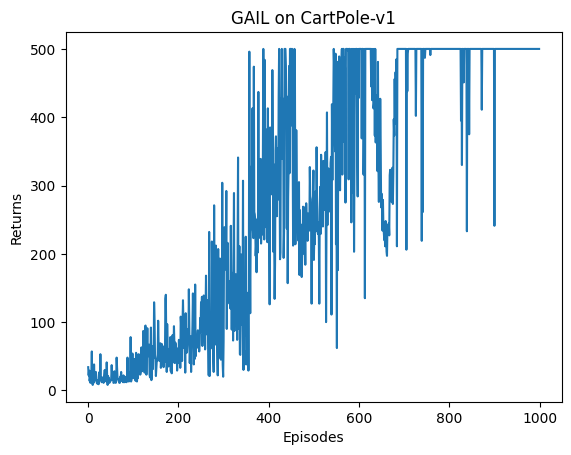

In [87]:
## 使用交叉熵损失
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

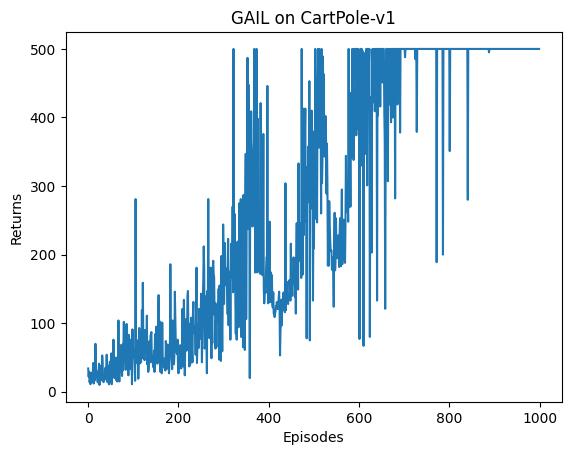

In [102]:
## 使用MSE损失
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()